In [1]:
from brian2 import *
from brian2modelfitting import *
import numpy as np
import pandas as pd
import scipy.io
from scipy import signal

WARNING    /home/xeniasterl/anaconda3/lib/python3.7/site-packages/brian2modelfitting/utils.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
 [py.warnings]


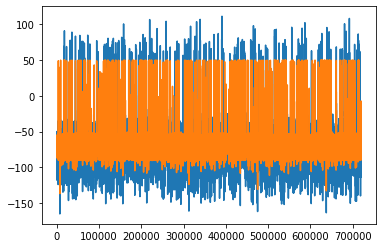

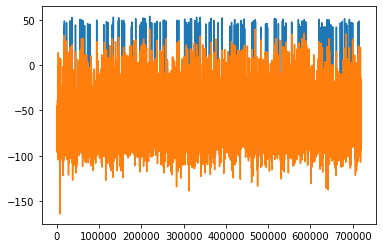

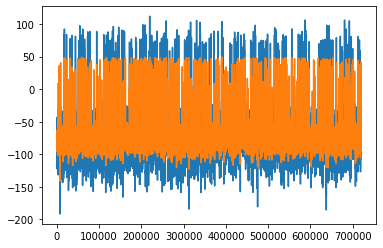

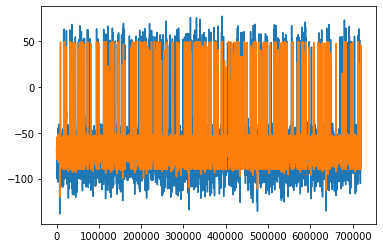

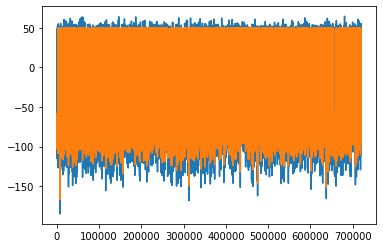

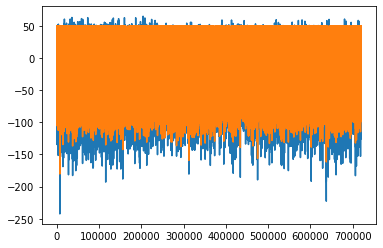

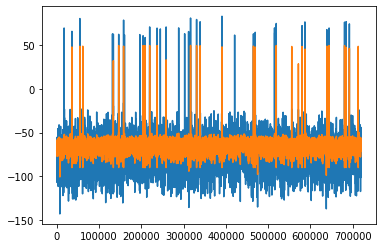

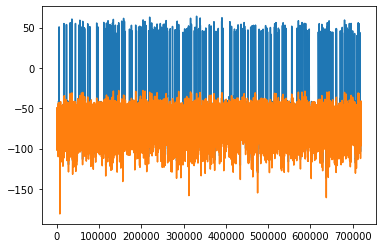

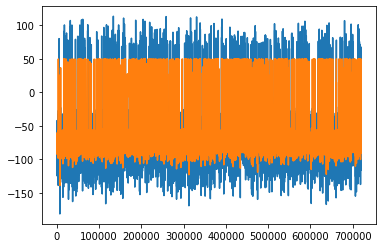

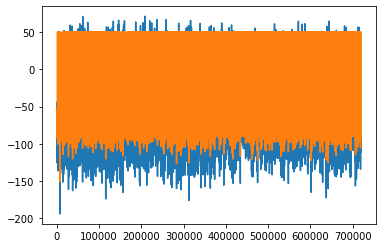

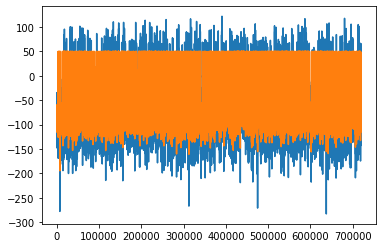

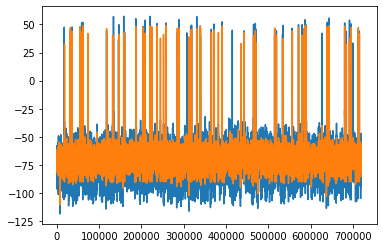

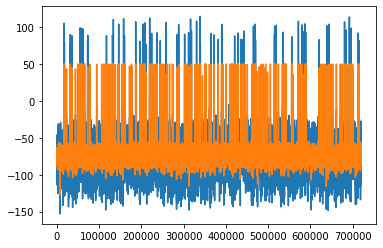

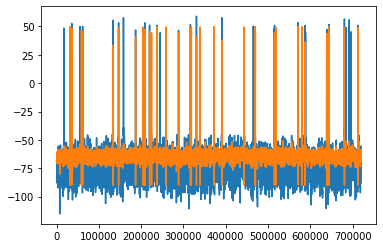

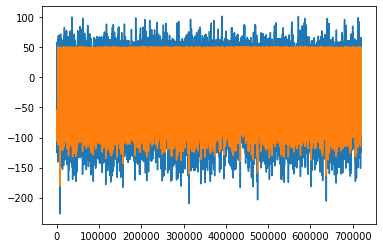

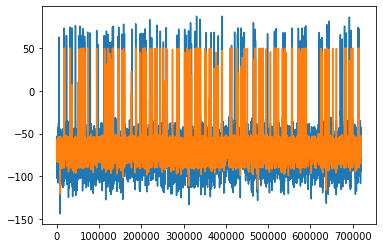

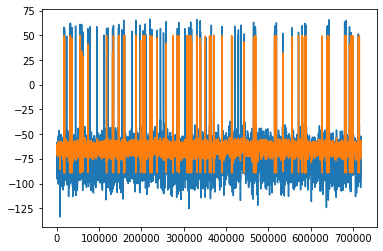

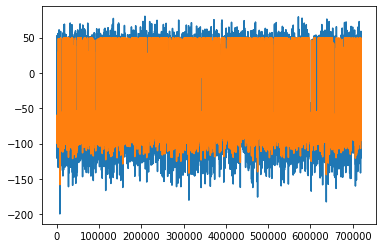

In [2]:
# Fit all parameters using TraceFitter

## Parameters
area = 20000*umetre**2
EL = -65*mV
EK = -90*mV
ENa = 50*mV
dt = 0.5*ms
VT = -63*mV
param = math.log(10) #used in neuron equations

## Create lists for saving results
result_list = []
fits_trace_list = []
fits_spike_list = []
spiketimes_fitted_list = []

# namelist = ['Pyramidaal_1_Dop', 'Pyramidaal_2_Dop', 'Pyramidaal_3_Dop', 'Pyramidaal_4_Dop', 'Pyramidaal_5_Dop', 
#             'Pyramidaal_6_Dop', 'Pyramidaal_7_Dop', 'Pyramidaal_8_Dop', 'Pyramidaal_9_Dop', 'Pyramidaal_10_Dop',
#             'Pyramidaal_11_Dop', 'Pyramidaal_12_Dop', 'Pyramidaal_13_Dop', 'Pyramidaal_14_Dop', 'Pyramidaal_15_Dop', 
#             'Pyramidaal_16_Dop', 'Pyramidaal_17_Dop', 'Pyramidaal_18_Dop', 'Pyramidaal_19_Dop', 'Pyramidaal_20_Dop']

# namelist = ['Pyramidaal_37_D2', 'Pyramidaal_38_D2', 'Pyramidaal_39_D2', 'Pyramidaal_40_D2', 'Pyramidaal_41_D2',
#             'Pyramidaal_42_D2', 'Pyramidaal_43_D2', 'Pyramidaal_44_D2', 'Pyramidaal_45_D2', 'Pyramidaal_46_D2',
#             'Pyramidaal_47_D2', 'Pyramidaal_48_D2', 'Pyramidaal_49_D2', 'Pyramidaal_50_D2', 'Pyramidaal_51_D2',
#             'Pyramidaal_52_D2', 'Pyramidaal_53_D2', 'Pyramidaal_54_D2']

namelist = ['Pyramidaal_55_D2', 'Pyramidaal_56_D2',
            'Pyramidaal_57_D2', 'Pyramidaal_58_D2', 'Pyramidaal_59_D2', 'Pyramidaal_60_D2', 'Pyramidaal_61_D2',
            'Pyramidaal_62_D2', 'Pyramidaal_63_D2', 'Pyramidaal_64_D2', 'Pyramidaal_65_D2', 'Pyramidaal_66_D2',
            'Pyramidaal_67_D2', 'Pyramidaal_68_D2', 'Pyramidaal_69_D2', 'Pyramidaal_70_D2', 'Pyramidaal_71_D2',
            'Pyramidaal_72_D2']

# namelist = ['Pyramidaal_21_D1', 'Pyramidaal_22_D1', 'Pyramidaal_23_D1', 'Pyramidaal_24_D1', 'Pyramidaal_25_D1', 
#             'Pyramidaal_26_D1', 'Pyramidaal_27_D1', 'Pyramidaal_28_D1', 'Pyramidaal_29_D1', 'Pyramidaal_30_D1',
#             'Pyramidaal_31_D1', 'Pyramidaal_32_D1', 'Pyramidaal_33_D1', 'Pyramidaal_34_D1', 'Pyramidaal_35_D1', 
#             'Pyramidaal_36_D1']

# spiketimes = scipy.io.loadmat('D1_spiketimes_pyramidaal_D1')
# spiketimes_array = spiketimes['spiketimes_cellarray']
# rows = spiketimes_array.shape[0]
# spiketimes_array = np.reshape(spiketimes_array, (rows,))

spiketimes = scipy.io.loadmat('D2_spiketimes_pyramidaal_D2')
spiketimes_array = spiketimes['spiketimes_cellarray']
rows = spiketimes_array.shape[0]
spiketimes_array = np.reshape(spiketimes_array, (rows,))
spiketimes_array = spiketimes_array[len(namelist):2*len(namelist)]

# spiketimes = scipy.io.loadmat('Dop_spiketimes_pyramidaal_Dop')
# spiketimes_array = spiketimes['spiketimes_cellarray']
# rows = spiketimes_array.shape[0]
# spiketimes_array = np.reshape(spiketimes_array, (rows,))

for name, spike_times in zip(namelist, spiketimes_array):
    
    data = scipy.io.loadmat(name)
    
    ## get output trace and resample
    out_trace = data['Data']['cell_response'][0][0].transpose()
    out_trace_resampled = signal.resample(out_trace, 720000, axis=1)
    out_trace_resampled = out_trace_resampled * pow(10, 3)
    out_trace = out_trace_resampled[0]
    
    ## get input current and resample
    in_current = data['Data']['input_current'][0][0].transpose()
    in_current_resampled = signal.resample(in_current, 720000, axis=1)
    in_current = in_current_resampled[0]
    
    ## Model Definition with all parameters to be fitted
    eqs = Equations(
    '''
    dv/dt = (gL*(EL-v) - gNa*(m*m*m)*h*(v-ENa) - gK*(n*n*n*n)*(v-EK) + I)/Cm : volt
    m = 1/(1+exp(-(v-Vh_m)/k_m)) : 1
    Vh_m = 3.583881*k_m-53.294451*mV : volt
    dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
        (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
    h = 1/(1+exp((v-Vh_h)/k_h)) : 1

    gK   : siemens (constant)
    gL   : siemens (constant)
    Cm   : farad (constant)
    gNa  : siemens (constant)
    k_m    : volt
    Vh_h   : volt
    k_h    : volt
    ''')

    ## Optimization and Metric Choice
    n_opt = NevergradOptimizer()
    metric = MSEMetric()

    ## Fitting
    fitter = TraceFitter(model=eqs, input_var='I', output_var='v',
                         input=[in_current]*amp, output=[out_trace]*mV, dt=dt,
                         n_samples=20,
                         param_init={'v': -65*mV},
                         method='exponential_euler')

    res, error_trace = fitter.fit(restart=True,
                            n_rounds=20,
                            optimizer=n_opt, metric=metric,
                            callback='progressbar',
                            gL = [1e-09 *siemens, 1e-07 *siemens],
                            gK = [6e-07*siemens, 6e-05*siemens],
                            Cm = [0.1*ufarad*cm**-2 * area, 2*ufarad*cm**-2 * area],
                            gNa = [2e-06*siemens, 2e-04*siemens],
                            k_m = [0*mV, 20*mV],
                            Vh_h = [-60*mV, 0*mV],
                            k_h = [0*mV, 20*mV])
    
    ## Visualization of the results
    fits_trace = fitter.generate_traces(params=None, param_init={'v': -65*mV})

#     plt.plot(out_trace.transpose())
#     plt.plot(fits_trace.transpose()/mV)

#     plt.show()

    # SpikeFitter

    ## Parameters volgens TraceFitter gefit op alles
    gL = res['gL']*siemens
    gK = res['gK']*siemens
    #Cm = res['Cm']

    ## Model Definition with only gNa, Vh_m, k_m, Vh_h and k_h to be fitted
    eqs = Equations(
    '''
    dv/dt = (gL*(EL-v) - gNa*(m*m*m)*h*(v-ENa) - gK*(n*n*n*n)*(v-EK) + I)/Cm : volt
    m = 1/(1+exp(-(v-Vh_m)/k_m)) : 1
    Vh_m = 3.583881*k_m-53.294451*mV : volt
    dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
        (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
    h = 1/(1+exp((v-Vh_h)/k_h)) : 1
    
    gNa    : siemens (constant)
    k_m    : volt
    Vh_h   : volt
    k_h    : volt
    Cm     : farad
    ''')

    ## Set optimizer and metric
    n_opt = NevergradOptimizer()
    metric = GammaFactor(delta=2*ms, time=360000*ms)

    ## pass parameters to the NeuronGroup
    fitter = SpikeFitter(model=eqs, input_var='I', dt=dt,
                         input=[in_current]*amp, output=spike_times,
                         n_samples=20,
                         threshold='m > 0.5',
                         param_init={'v': -70*mV},
                         reset=None,
                         refractory=2*ms)

    result_dict, error_spike = fitter.fit(n_rounds=20,
                                    optimizer=n_opt,
                                    metric=metric,
                                    callback='progressbar',
                                    Cm = [0.1*ufarad*cm**-2 * area, 2*ufarad*cm**-2 * area],
                                    gNa = [2e-06*siemens, 2e-04*siemens],
                                    k_m = [0*mV, 20*mV],
                                    Vh_h = [-60*mV, 0*mV],
                                    k_h = [0*mV, 20*mV])
    
    ## Generate fitted spike times and trace
    spikes = fitter.generate_spikes(params=None)

    fits_spike = fitter.generate(params=None,
                           output_var='v')

    ## Visualization of the results
    plt.plot(out_trace.transpose())
    plt.plot(fits_spike.transpose()/mV)

    plt.show()
    
    ## Save fitted parameters, traces and spike times
    gNa = result_dict['gNa']
    k_m = result_dict['k_m']
    k_h = result_dict['k_h']
    Vh_h = result_dict['Vh_h']
    Cm = result_dict['Cm']
    
    result_list.append([gL, gK, Cm, gNa, k_m, k_h, Vh_h, error_spike, error_trace])
    fits_trace_list.append(fits_trace)
    fits_spike_list.append(fits_spike)
    spiketimes_fitted_list.append(spikes)
    
    ## Delete variables before next round
    del gL, gK, Cm, gNa, k_m, k_h, Vh_h
    
result_array = np.asarray(result_list)
fits_trace_array = np.asarray(fits_trace_list)
fits_spike_array = np.asarray(fits_spike_list)
spiketimes_fitted_array = np.asarray(spiketimes_fitted_list)

# np.save('Dop_results_pyramidaal_Dop.npy', result_array)
# np.save('Dop_fitted_trace_pyramidaal_Dop.npy', fits_trace_array)
# np.save('Dop_fitted_spike_pyramidaal_Dop.npy', fits_spike_array)
# np.save('Dop_fitted_spiketimes_pyramidaal_Dop.npy', spiketimes_fitted_array)

# np.save('D1_results_pyramidaal_D1.npy', result_array)
# np.save('D1_fitted_trace_pyramidaal_D1.npy', fits_trace_array)
# np.save('D1_fitted_spike_pyramidaal_D1.npy', fits_spike_array)
# np.save('D1_fitted_spiketimes_pyramidaal_D1.npy', spiketimes_fitted_array)

np.save('D2_results_pyramidaal_D2_2.npy', result_array)
np.save('D2_fitted_trace_pyramidaal_D2_2.npy', fits_trace_array)
np.save('D2_fitted_spike_pyramidaal_D2_2.npy', fits_spike_array)
np.save('D2_fitted_spiketimes_pyramidaal_D2_2.npy', spiketimes_fitted_array)